In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# $\frac{du}{dt}=2cos(u)+4sin(u)$ \\
$F(u)=4sin(u)$

In [79]:
import numpy as np

## solver ###
T=1000

dt=0.05
N=30
u=np.zeros([N,T])

## initial condition ####

for i in range(0,N):
  u[i,0]=np.abs(np.cos(i))


### Training data #####
for k in range(1,T):
    u[:,k]=u[:,k-1]+2*(np.cos(u[:,k-1]))+4*np.sin(u[:,k-1])



In [80]:
def diff_solver(u0,m,phi):
  v=np.zeros([N,m])
  v[:,0]=u0.flatten()
  for k in range(1,m):
      v[:,k]=v[:,k-1]+2*(np.cos(v[:,k-1]))+phi
  return v 

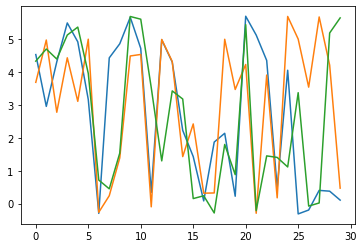

In [82]:
import matplotlib.pyplot as plt
plt.plot(u[:,10])
plt.plot(u[:,20])
plt.plot(u[:,990])






In [83]:
import keras
from keras.layers import Input, Dense, Lambda
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adagrad, Adadelta
from keras.callbacks import History
history = History()

###########
trainN=900
train_input = u[:,0:trainN]
##############
def swish(x):
   beta = 1.0
   return beta * x * keras.backend.sigmoid(x)


input_shape =np.size(u,0)
hidden_size=30
input_data = Input(shape=(30,))
x = Dense(hidden_size, activation=swish)(input_data)
x = Dense(hidden_size, activation=swish)(x)
x = Dense(hidden_size, activation=swish)(x)
x = Dense(hidden_size, activation=swish)(x)
x = Dense(30, activation=None)(x)

neural_net= Model (input_data,x)
neural_net.compile(loss='mse',optimizer='adam')
neural_net.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_26 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_27 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_28 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_29 (Dense)             (None, 30)                930       
Total params: 4,650
Trainable params: 4,650
Non-trainable params: 0
_________________________________________________________

In [ ]:
#### Training ########
time_step=int(1)
for loop in range(1,trainN):
 print('loop', loop)
 if (loop==1): 
  flux = neural_net.predict(u[:,0].reshape([1,30]))  
  pred_nextime = diff_solver(u[:,0].reshape([30,1]),1,flux)
  hist = neural_net.fit(pred_nextime.reshape([1,30]), u[:,loop].reshape([1,30]),
                       batch_size = 1,
             verbose=1,
             epochs = 5,
             callbacks=[keras.callbacks.ModelCheckpoint('best_weights.h5',
                                                    verbose=1),history]
             )
  
 else:
  neural_net.load_weights('best_weights.h5')
  flux = neural_net.predict(u[:,loop-1].reshape([1,30]))  
  pred_nextime = diff_solver(u[:,loop-1].reshape([30,1]),1,flux)
  hist = neural_net.fit(pred_nextime.reshape([1,30]), u[:,loop].reshape([1,30]),
                       batch_size = 1,
             verbose=1,
             epochs = 5,
             callbacks=[keras.callbacks.ModelCheckpoint('best_weights.h5',
                                                    verbose=1),history]
             )

  

Streaming output truncated to the last 5000 lines.
Epoch 00005: saving model to best_weights.h5
loop 225
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 4.1964

Epoch 00001: saving model to best_weights.h5
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 4.1960

Epoch 00002: saving model to best_weights.h5
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 4.1582

Epoch 00003: saving model to best_weights.h5
Epoch 4/5
1/1 [==============================] - 0s 17ms/step - loss: 4.0902

Epoch 00004: saving model to best_weights.h5
Epoch 5/5
1/1 [==============================] - 0s 10ms/step - loss: 4.0002

Epoch 00005: saving model to best_weights.h5
loop 226
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 5.2881

Epoch 00001: saving model to best_weights.h5
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 5.2798

Epoch 00002: saving model to best_weights.h5
Epoch 3/5
1/1 [==============

Parameterization tests in offline model. 

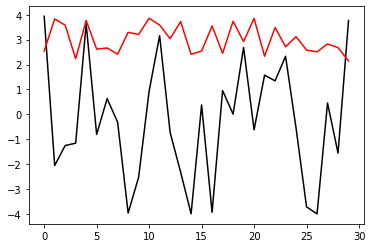

In [67]:
u_test = u[:,trainN:]
neural_net.load_weights('best_weights.h5')
flux_truth = 4*np.sin(u_test[:,10])
flux_pred = neural_net.predict(u_test[:,10].reshape([1,30]))

plt.plot(flux_truth,'k')
plt.plot(flux_pred[0,:],'r')


Parameterization tests in online mode

In [77]:
t=20
upred_online=np.zeros([N,t])
for k in range(1,t):
  if (k==1):
   upred_online[:,k] = (diff_solver(u_test[:,0],1,neural_net.predict(u_test[:,0].reshape([1,30])).reshape([30,1]))).flatten()
  else:
   upred_online[:,k] = diff_solver(upred_online[:,k-1],1,neural_net.predict(upred_online[:,k-1].reshape([1,30])).reshape([30,1])).flatten() 


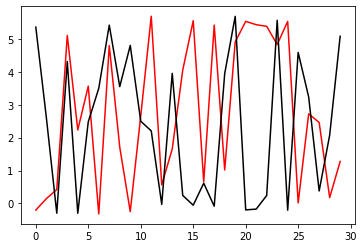

In [78]:
t=1
plt.plot(upred_online[:,t],'r')
plt.plot(u_test[:,t+1],'k')

